# Book Classification - Afprøvning 3 og 4¶

## Imports

In [8]:
import os
import pickle
import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph.
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from wordcloud import WordCloud

import string

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

import warnings
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

import re
from collections import defaultdict, Counter

In [9]:
import nltk
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')


[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\rasmu\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rasmu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rasmu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\rasmu\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rasmu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Preprocessing functions

In [12]:
# These prepocessing functions is based on the following: https://github.com/vijayaiitk/NLP-text-classification-model
# These functions has been slightly modified
    
text = "100,000 years ago, at least six human species inhabited the earth. Today there is just one. New york times"


def preprocess(text):
    text = text.lower() 
    text=text.strip()  
    text=re.compile('<.*?>').sub('', text)
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text)
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    
    
    text = re.sub(r'one',' ',text)
    text = re.sub(r'less',' ',text)
    text = re.sub(r'new',' ',text)
    text = re.sub(r'life',' ',text)
    text = re.sub(r'world',' ',text)
    text = re.sub(r'time',' ',text)
    text = re.sub(r'find',' ',text)
    text = re.sub(r'know',' ',text)
    text = re.sub(r'year',' ',text)
    text = re.sub(r'make',' ',text)
    
    text = re.sub(r'new york time','',text)
    text = re.sub(r'cover edition','',text)
    text = re.sub(r'pulitzer prize','',text)
    text = re.sub(r'bestselling','',text)
    
    
    return text
text=preprocess(text)
print(text)

  s ago at least six human species inhabited the earth today there is just     york  s


In [14]:
text = "100,000 years ago, at least six human species inhabited the earth. Today there is just one. New york times"

 
#1. STOPWORD REMOVAL
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)

text=stopword(text)
print(text)

#2. STEMMING
 
snow = SnowballStemmer('english')
def stemming(string):
    a=[snow.stem(i) for i in word_tokenize(string) ]
    return " ".join(a)
text=stemming(text)
print(text)

#3. LEMMATIZATION

wl = WordNetLemmatizer()
 
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    

# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

text = lemmatizer(text)
print(text)

100,000 years ago, least six human species inhabited earth. Today one. New york times
100,000 year ago , least six human speci inhabit earth . today one . new york time
100,000 year ago , least six human speci inhabit earth . today one . new york time


In [15]:
def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))

## Get TagMyBook data and removing science fiction

In [16]:
df = pd.read_csv('data.csv')

df.drop(df.loc[df['genre']=='science_fiction'].index, inplace=True)
df.reset_index(drop=True, inplace=True)
display(df)

,Unnamed: 0,title,rating,name,num_ratings,num_reviews,num_followers,synopsis,genre
0,0,Sapiens: A Brief History of Humankind,4.39,Yuval Noah Harari,"8,06,229","46,149",30.5k,"100,000 years ago, at least six human species ...",history
1,1,"Guns, Germs, and Steel: The Fates of Human Soc...",4.04,Jared Diamond,"3,67,056","12,879","6,538","""Diamond has written a book of remarkable scop...",history
2,2,A People's History of the United States,4.07,Howard Zinn,"2,24,620","6,509","2,354","In the book, Zinn presented a different side o...",history
3,3,"The Devil in the White City: Murder, Magic, an...",3.99,Erik Larson,"6,13,157","36,644",64.2k,Author Erik Larson imbues the incredible event...,history
4,4,The Diary of a Young Girl,4.18,Anne Frank,"33,13,033","35,591","4,621",Discovered in the attic in which she spent the...,history
...,...,...,...,...,...,...,...,...,...
1489,1534,Hounded,4.09,Kevin Hearne,"83,827","7,203","11,905","Atticus O’Sullivan, last of the Druids, lives ...",fantasy
1490,1535,Charlie and the Chocolate Factory,4.15,Roald Dahl,"7,75,001","14,252","22,897",Charlie Bucket's wonderful adventure begins wh...,fantasy
1491,1536,Red Rising,4.25,Pierce Brown,"3,10,138","30,388","30,510","""I live for the dream that my children will be...",fantasy
1492,1537,Frostbite,4.26,Richelle Mead,"3,37,538","12,435","66,448","Rose loves Dimitri, Dimitri might love Tasha, ...",fantasy


### Clean synopsis - Skip this and download pickle instead

In [19]:
df['clean_synopsis'] = df['synopsis'].apply(lambda x: finalpreprocess(x))
with open('cleansedData1.pickle', 'wb') as f:
    pickle.dump(df, f, pickle.HIGHEST_PROTOCOL)

# Download pickle

In [20]:
with open('cleansedData1.pickle', 'rb') as f:
    df = pickle.load(f)
display(df)

,Unnamed: 0,title,rating,name,num_ratings,num_reviews,num_followers,synopsis,genre,clean_synopsis
0,0,Sapiens: A Brief History of Humankind,4.39,Yuval Noah Harari,"8,06,229","46,149",30.5k,"100,000 years ago, at least six human species ...",history,ago least six human specie inhabit earth today...
1,1,"Guns, Germs, and Steel: The Fates of Human Soc...",4.04,Jared Diamond,"3,67,056","12,879","6,538","""Diamond has written a book of remarkable scop...",history,diamond write book remarkable scope important ...
2,2,A People's History of the United States,4.07,Howard Zinn,"2,24,620","6,509","2,354","In the book, Zinn presented a different side o...",history,book zinn present different side history tradi...
3,3,"The Devil in the White City: Murder, Magic, an...",3.99,Erik Larson,"6,13,157","36,644",64.2k,Author Erik Larson imbues the incredible event...,history,author erik larson imbues incredible event sur...
4,4,The Diary of a Young Girl,4.18,Anne Frank,"33,13,033","35,591","4,621",Discovered in the attic in which she spent the...,history,discover attic spent last anne frank remarkabl...
...,...,...,...,...,...,...,...,...,...,...
1489,1534,Hounded,4.09,Kevin Hearne,"83,827","7,203","11,905","Atticus O’Sullivan, last of the Druids, lives ...",fantasy,atticus osullivan last druid live peacefully a...
1490,1535,Charlie and the Chocolate Factory,4.15,Roald Dahl,"7,75,001","14,252","22,897",Charlie Bucket's wonderful adventure begins wh...,fantasy,charlie bucket wonderful adventure begin mr wi...
1491,1536,Red Rising,4.25,Pierce Brown,"3,10,138","30,388","30,510","""I live for the dream that my children will be...",fantasy,live dream child bear free say like land fathe...
1492,1537,Frostbite,4.26,Richelle Mead,"3,37,538","12,435","66,448","Rose loves Dimitri, Dimitri might love Tasha, ...",fantasy,rise love dimitri dimitri might love tasha mas...


# N-grams visualization

In [21]:
def generate_N_grams(text,ngram=1):
    words=[word for word in text.split(" ")]  
    temp=zip(*[words[i:] for i in range(0,ngram)])
    ans=[' '.join(ngram) for ngram in temp]
    return ans

In [22]:
def plot_genre_ngram(genre,ngram_size = 2):
    genreValues=defaultdict(int)
    for text in df[df.genre==genre].clean_synopsis:
        for word in generate_N_grams(text,ngram_size):
            genreValues[word]+=1
            
    df_genre=pd.DataFrame(sorted(genreValues.items(), key=lambda x:x[1], reverse=True))
    
    genre_ngram=df_genre[0][:10]
    genre_count=df_genre[1][:10]
    
    plt.figure(1,figsize=(16, 4))
    plt.bar(genre_ngram, genre_count, color ='green', width = 0.4)
    plt.xlabel(f'Words in {genre} dataframe')
    plt.ylabel("Count")
    plt.title(f"{genre.capitalize()} {ngram_size}-gram Analysis", fontsize=28)
    plt.xticks(rotation=45)
    plt.show()

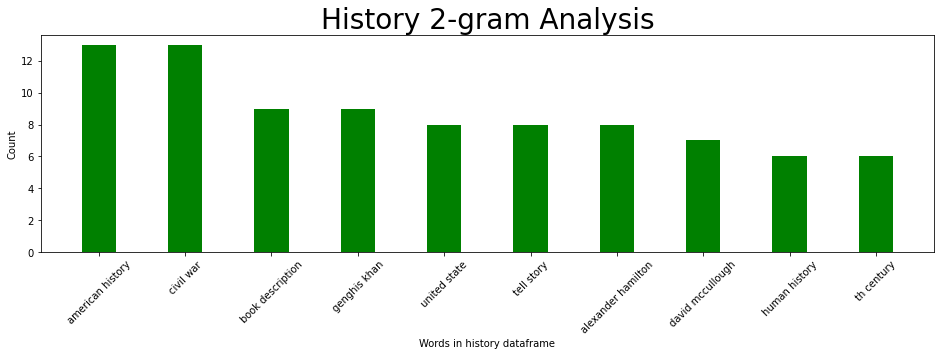

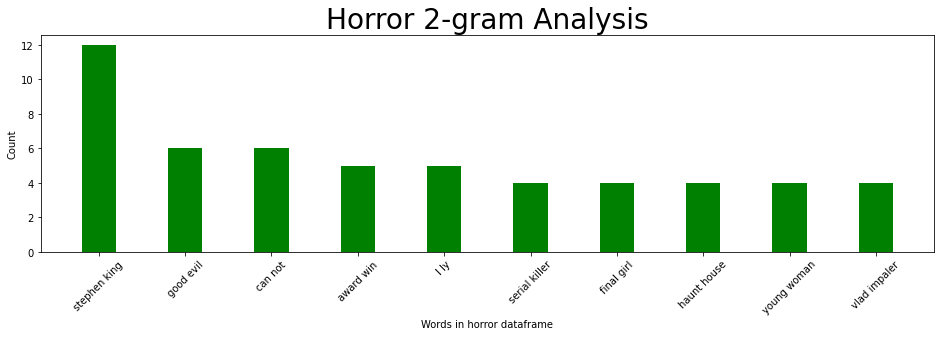

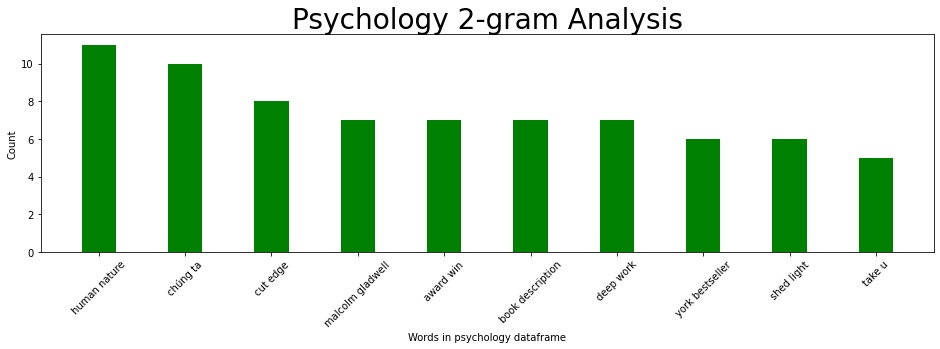

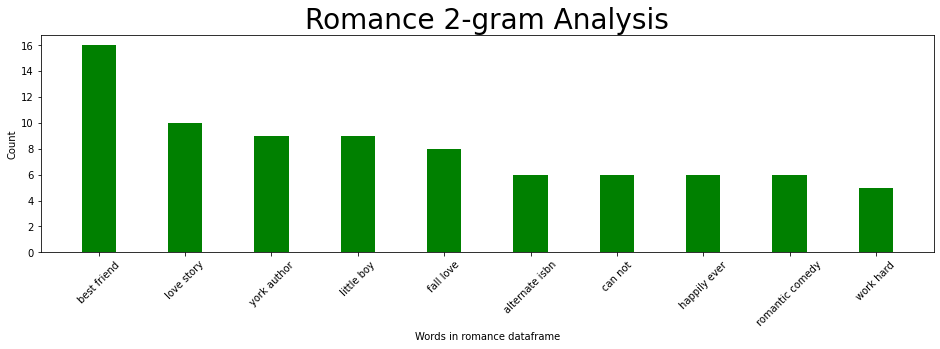

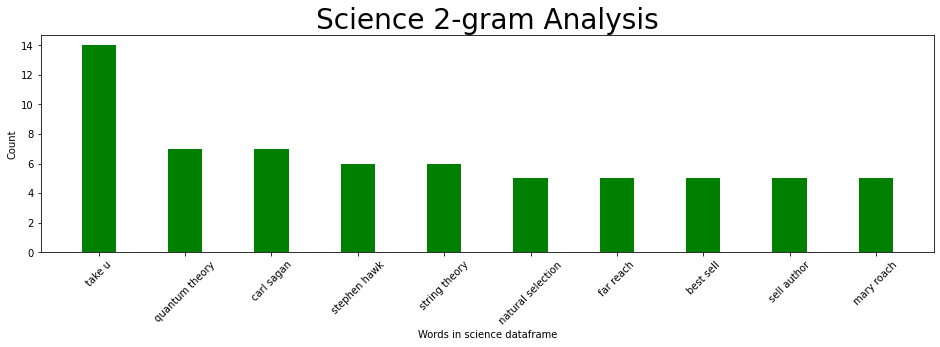

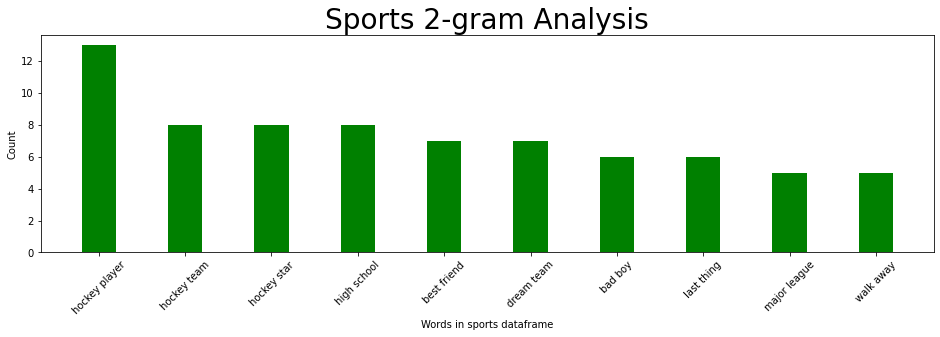

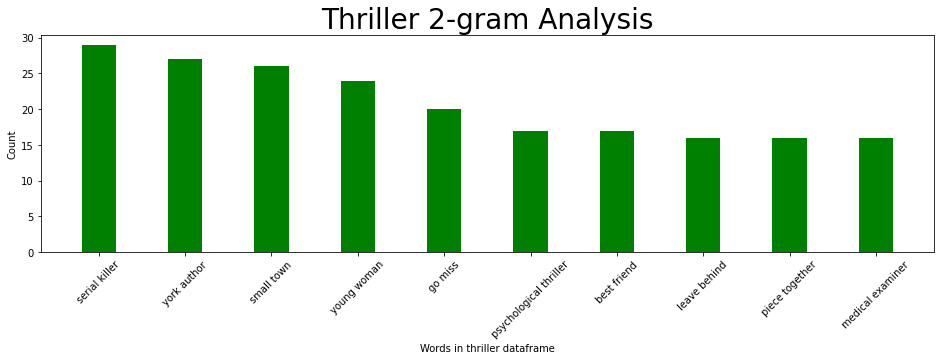

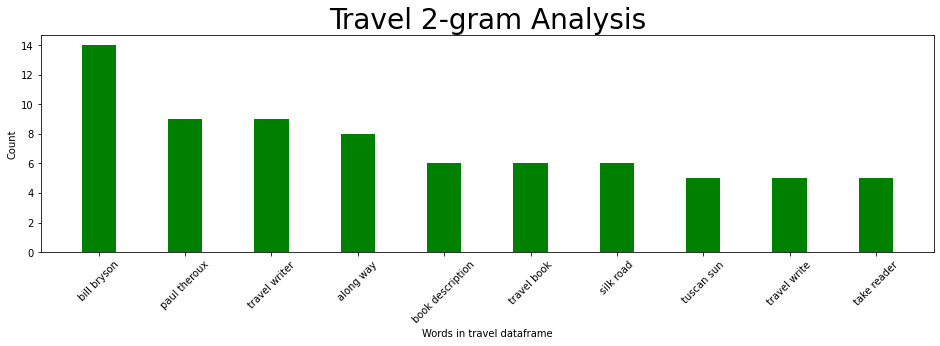

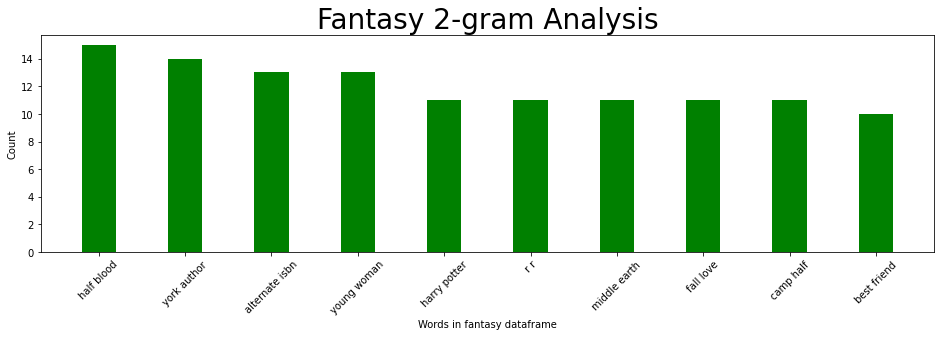

In [23]:
genres = df['genre'].unique()
for genre in genres:
    plot_genre_ngram(genre,2)

# Wordcloud visualization

In [24]:
def word_cloud(genre):
    df_genre = df.loc[df['genre']==genre]
    text = ' '.join(genre for genre in df_genre.clean_synopsis)
    wordcloud = WordCloud().generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.savefig(f'{genre}.pdf',bbox_inches='tight')
    plt.axis("off")
    plt.title(genre.capitalize(),fontsize=28)
    plt.show()

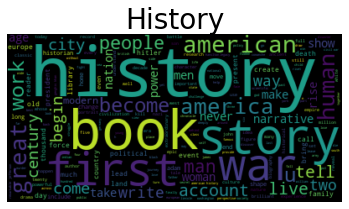

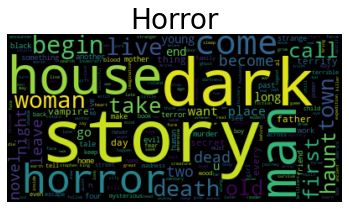

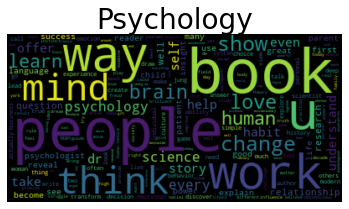

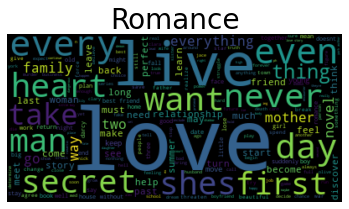

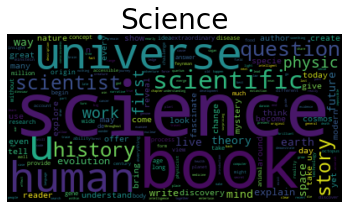

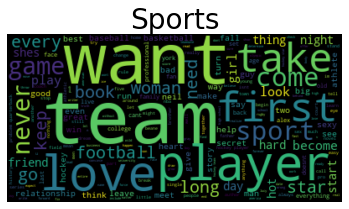

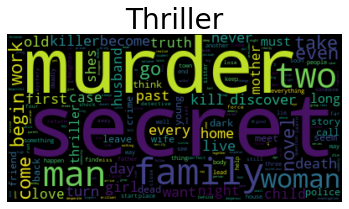

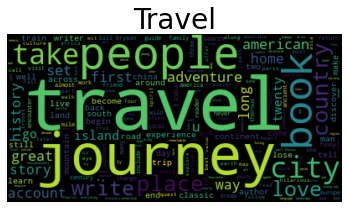

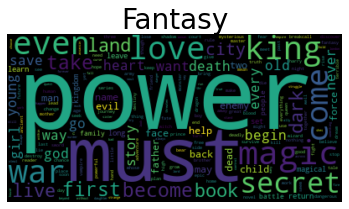

In [25]:
genres = df['genre'].unique()
for genre in genres:
    word_cloud(genre)


### Add columns with category ids as numbers

In [26]:
# Create a new column 'category_id' with encoded categories 
df['category_id'] = df['genre'].factorize()[0]
category_id_df = df[['genre', 'category_id']].drop_duplicates()
display(category_id_df)

# Dictionaries for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'genre']].values)

horror_thriller_ids = [category_to_id[genre] for genre in ['horror', 'thriller']]
df['horror or thriller'] = df['category_id'].apply(lambda x: 1 if x in horror_thriller_ids else 0)
df.sample(10)


,genre,category_id
0,history,0
99,horror,1
199,psychology,2
298,romance,3
409,science,4
488,sports,5
567,thriller,6
1048,travel,7
1146,fantasy,8


,Unnamed: 0,title,rating,name,num_ratings,num_reviews,num_followers,synopsis,genre,clean_synopsis,category_id,horror or thriller
1449,1494,Dead Beat,4.40,Jim Butcher,"1,18,902","4,152","45,552","Meet Harry Dresden, Chicago's first (and only)...",fantasy,meet harry dresden chicago first wizard p turn...,8,0
1408,1453,Foundryside,4.21,Robert Jackson Bennett,"29,529","4,646","17,461","Sancia Grado is a thief, and a damn good one. ...",fantasy,sancia grado thief damn good late target heavi...,8,0
515,560,Seabiscuit: An American Legend,4.21,Laura Hillenbrand,"1,58,018","4,723","3,838",There's an alternate cover edition here\n\nSea...,sports,alternate seabiscuit electrify popular attract...,5,0
36,36,In the Heart of the Sea: The Tragedy of the Wh...,4.13,Nathaniel Philbrick,"1,00,046","6,472","2,859","""With its huge, scarred head halfway out of th...",history,huge scar head halfway water tail beat ocean w...,0,0
694,739,Map of Bones,4.08,James Rollins,"59,285","1,765","12,264",The bones lead to ancient mysteries and presen...,thriller,b lead ancient mystery present day terror foll...,6,1
130,130,Into the Drowning Deep,3.99,Mira Grant,"23,885","5,275","5,027 followers","Seven years ago, the Atargatis set off on a vo...",horror,seven ago atargatis set voyage mariana trench ...,1,1
501,546,The Crossover,4.26,Kwame Alexander,"52,099","8,428","2,434","""With a bolt of lightning on my kicks . . .The...",sports,bolt lightning kick court sizzle sweat drizzle...,5,0
1010,1055,When the Stars Go Dark,3.87,Paula McLain,"45,079","5,463","5,337",Anna Hart is a missing persons detective in Sa...,thriller,anna hart miss person detective san francisco ...,6,1
587,632,Into the Water,3.59,Paula Hawkins,"3,46,335","27,076","31,712",The author of the #1 New York Times bestseller...,thriller,author york bestseller global phenomenon girl ...,6,1
243,243,The Willpower Instinct: How Self-Control Works...,4.12,Kelly McGonigal,"30,178","2,019","1,462",The first book to explain the new science of s...,psychology,first book explain science self control harnes...,2,0


## Visualize the data using Bar chart

genre
fantasy       348
history        99
horror        100
psychology     99
romance       111
science        79
sports         79
thriller      481
travel         98
Name: genre, dtype: int64

<Figure size 576x432 with 0 Axes>

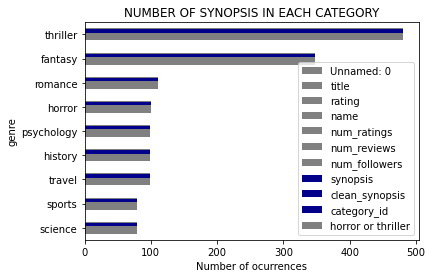

In [27]:
fig = plt.figure(figsize=(8,6))
colors = ['grey','grey','grey','grey','grey','grey','grey','darkblue','darkblue','darkblue']
df.groupby('genre').count().sort_values(['category_id']).plot.barh(
    ylim=0, color=colors, title= 'NUMBER OF SYNOPSIS IN EACH CATEGORY')
plt.xlabel('Number of ocurrences', fontsize = 10);

display(df.groupby('genre')['genre'].count())



## Create new dataframe with large categories undersampled

In [28]:
median = np.median([df[df.category_id==_id].category_id.count() for _id in df.category_id.unique()])
maxi = int(median * 1.5)
counts = defaultdict(int)
ix_to_drop = []
for _id in df.category_id.unique():
  ixs = df[df.category_id==_id].index.sort_values()
  ix_to_drop.extend(ixs[maxi:])
df2 = df.drop(ix_to_drop)
df2.info()
df_undersamples = df2

df_oversamples = df.iloc[ix_to_drop]
df_oversamples.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 961 entries, 0 to 1293
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          961 non-null    int64  
 1   title               961 non-null    object 
 2   rating              961 non-null    float64
 3   name                961 non-null    object 
 4   num_ratings         961 non-null    object 
 5   num_reviews         961 non-null    object 
 6   num_followers       961 non-null    object 
 7   synopsis            961 non-null    object 
 8   genre               961 non-null    object 
 9   clean_synopsis      961 non-null    object 
 10  category_id         961 non-null    int64  
 11  horror or thriller  961 non-null    int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 97.6+ KB


,Unnamed: 0,title,rating,name,num_ratings,num_reviews,num_followers,synopsis,genre,clean_synopsis,category_id,horror or thriller
715,760,The Cousins,3.81,Karen M. McManus,"78,052","9,319","23,248","Milly, Aubrey, and Jonah Story are cousins, bu...",thriller,milly aubrey jonah story cousin barely never e...,6,1
716,761,Rainbow Six,4.11,Tom Clancy,"51,714","1,296","7,109","Over the course of nine novels, Tom Clancy’s “...",thriller,course nine novel tom clancys genius big compe...,6,1
717,762,Fool Me Once,3.94,Harlan Coben,"88,808","6,344","28,792","Former special ops pilot Maya, home from the w...",thriller,former special ops pilot maya home war see unt...,6,1
718,763,Zero Day,4.04,David Baldacci,"73,419","3,953","1,14,326",War hero John Puller is known to be the top in...,thriller,war hero john puller n top investigator u army...,6,1
719,764,Still Life With Crows,4.19,Douglas Preston,"36,137","1,819","10,785",A small Kansas town has turned into a killing ...,thriller,small kansa town turn kill ground serial kille...,6,1


# Training with undersamples

In [29]:
tfidf = TfidfVectorizer(use_idf=True, sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')
# We transform each 'clean text' into a vector
features = tfidf.fit_transform(df2.clean_synopsis).toarray()
labels = df2.category_id
print("Each of the %d 'clean text' is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))


Each of the 961 'clean text' is represented by 2993 features (TF-IDF score of unigrams and bigrams)


In [30]:
def test():
  # run block of code and catch warnings
  with warnings.catch_warnings():
    # Finding the three most correlated terms with each of the product categories
    N = 3
    for genre, category_id in sorted(category_to_id.items()):
      features_chi2 = chi2(features, labels == category_id)
      indices = np.argsort(features_chi2[0])
      feature_names = np.array(tfidf.get_feature_names())[indices]
      unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
      bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
      print(f"\n==> {genre}:")
      print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
      print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))
test()


==> fantasy:
  * Most Correlated Unigrams are: lord, magic, dragon
  * Most Correlated Bigrams are: middle earth, harry potter, half blood

==> history:
  * Most Correlated Unigrams are: civil, hitler, history
  * Most Correlated Bigrams are: thomas jefferson, american history, civil war

==> horror:
  * Most Correlated Unigrams are: haunt, eerie, horror
  * Most Correlated Bigrams are: place live, good evil, stephen king

==> psychology:
  * Most Correlated Unigrams are: jung, psychologist, psychology
  * Most Correlated Bigrams are: shed light, malcolm gladwell, human nature

==> romance:
  * Most Correlated Unigrams are: darcy, romantic, love
  * Most Correlated Bigrams are: romantic comedy, best friend, love story

==> science:
  * Most Correlated Unigrams are: scientific, science, universe
  * Most Correlated Bigrams are: quantum theory, mary roach, carl sagan

==> sports:
  * Most Correlated Unigrams are: team, player, hockey
  * Most Correlated Bigrams are: hockey team, hockey 

In [31]:
X = df2['clean_synopsis'] # Collection of 'clean synopsis'
y = df2['genre'] # Target or the labels we want to predict (i.e., the 10 different genres)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.20,
                                                    random_state = 1)


## Models to evaluate

In [32]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=6, random_state=0),
    LinearSVC(),
    LogisticRegression(random_state=0, solver = 'liblinear', C=10, penalty = 'l2'),
]

In [33]:
# 5 Cross-validation
CV = 3
cv_df = pd.DataFrame(index=range(CV * len(models)))

In [34]:
from sklearn.model_selection import cross_validate
entries = []

for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
display(cv_df)

,model_name,fold_idx,accuracy
0,RandomForestClassifier,0,0.582555
1,RandomForestClassifier,1,0.521875
2,RandomForestClassifier,2,0.500000
3,LinearSVC,0,0.794393
4,LinearSVC,1,0.712500
5,LinearSVC,2,0.718750
6,LogisticRegression,0,0.788162
7,LogisticRegression,1,0.709375
8,LogisticRegression,2,0.718750


## Model performance

In [35]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.741881,0.045584
LogisticRegression,0.738762,0.043037
RandomForestClassifier,0.534810,0.042770


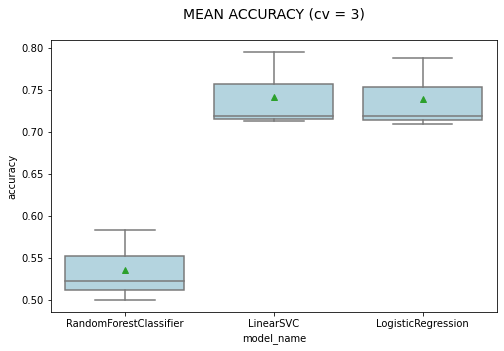

In [36]:
plt.figure(figsize=(8,5))
sns.boxplot(x='model_name', y='accuracy', 
            data=cv_df, 
            color='lightblue', 
            showmeans=True)
plt.title("MEAN ACCURACY (cv = 3)\n", size=14);

In [37]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, 
                                                               labels, 
                                                               df2.index, test_size=0.20, 
                                                               random_state=1)

model = LinearSVC()
model.fit(X_train, y_train)
y_pred_linearSVC = model.predict(X_test)

model = LogisticRegression(random_state=0, solver = 'liblinear', C=10, penalty = 'l2')
model.fit(X_train, y_train)
y_pred_logisticRegression = model.predict(X_test)
proba_logisticRegression = model.predict_proba(X_test)

model = RandomForestClassifier(n_estimators=200, max_depth=6, random_state=0, max_features="sqrt")
model.fit(X_train, y_train)
y_pred_RFC = model.predict(X_test) 


## Classification reports

In [38]:
names = ["linearSVC", "logisticRegression", "RandomForest"]
for name, y_pred in zip(names, [y_pred_linearSVC, y_pred_logisticRegression, y_pred_RFC]):
  print(f'\t{name} CLASSIFICATIION METRICS\n')
  print(metrics.classification_report(y_test, y_pred, target_names= df['genre'].unique()))
  print()

	linearSVC CLASSIFICATIION METRICS

              precision    recall  f1-score   support

     history       0.77      0.77      0.77        22
      horror       0.60      0.63      0.62        19
  psychology       0.89      0.84      0.86        19
     romance       0.67      0.43      0.53        23
     science       0.89      0.85      0.87        20
      sports       0.76      0.81      0.79        16
    thriller       0.57      0.65      0.61        26
      travel       0.77      0.85      0.81        20
     fantasy       0.87      0.93      0.90        28

    accuracy                           0.75       193
   macro avg       0.75      0.75      0.75       193
weighted avg       0.75      0.75      0.75       193


	logisticRegression CLASSIFICATIION METRICS

              precision    recall  f1-score   support

     history       0.78      0.82      0.80        22
      horror       0.52      0.58      0.55        19
  psychology       0.94      0.79      0.86       

In [39]:
def plot_confusion(y_test, y_pred, title, figsize=(8,8)):
  conf_mat = confusion_matrix(y_test, y_pred)
  fig, ax = plt.subplots(figsize=figsize)
  sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
              xticklabels=category_id_df.genre.values, 
              yticklabels=category_id_df.genre.values)
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.title(f"{title}", size=16);


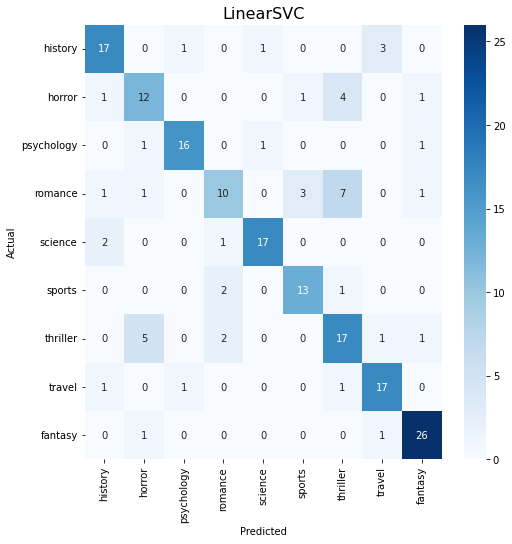

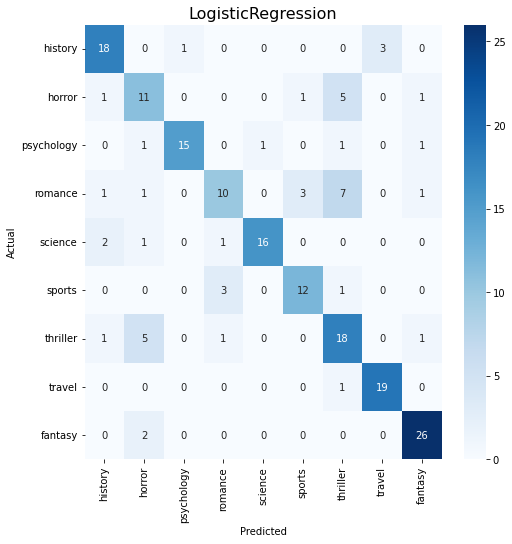

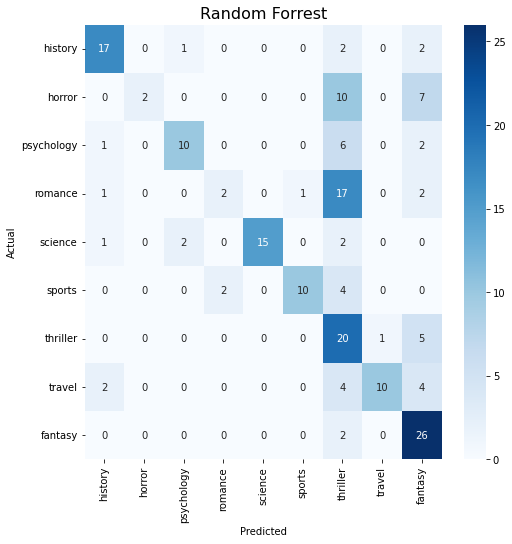

In [40]:
plot_confusion(y_test, y_pred_linearSVC, "LinearSVC")
plot_confusion(y_test, y_pred_logisticRegression, "LogisticRegression")
plot_confusion(y_test, y_pred_RFC, "Random Forrest")


# Try different models with StratifiedKfold - Afprøvning 4

In [41]:
# models to evaluate
models = [
    LinearSVC(),
    LogisticRegression(random_state=0, solver = 'liblinear', C=10, penalty = 'l2'),
    RandomForestClassifier(n_estimators=200, max_depth=10, random_state=0),
]
model_names = ["LinearSVC", "LogisticRegression", "RandomForestClassifier"]

In [42]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from statistics import mean, stdev

_df = df

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=3,
                        # max_features=100, 
                        ngram_range=(1, 2), 
                        stop_words='english')
# We transform each 'clean text' into a vector
features = tfidf.fit_transform(_df.clean_synopsis).toarray()
#features = tfidf.fit_transform(_df.synopsis).toarray()
labels = _df["genre"]
df_features = pd.DataFrame(features)
df_labels = pd.DataFrame(labels)

print("Each of the %d 'clean text' is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

entries = []
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    for model, model_name in zip(models, model_names):
        accu_stratified = []
        precisions = []
        recalls = []
        f1_scores = []
        for fold_idx, (train_index, test_index) in enumerate(skf.split(features, labels), 0):
            X_train_fold, X_test_fold = df_features.iloc[train_index], df_features.iloc[test_index]
            y_train_fold, y_test_fold = df_labels.iloc[train_index], df_labels.iloc[test_index]

            # model = LogisticRegression(random_state=0, solver = 'liblinear', C=10, penalty = 'l2')
            model.fit(X_train_fold, y_train_fold)
            accuracy = model.score(X_test_fold, y_test_fold)
            accu_stratified.append(accuracy)

            y_pred = model.predict(X_test_fold)
            
            precision = metrics.precision_score(y_test_fold, y_pred, average='weighted')
            recall = metrics.recall_score(y_test_fold, y_pred, average='weighted')
            f1_score = metrics.f1_score(y_test_fold, y_pred, average='weighted')
            precisions.append(precision)
            recalls.append(recall)
            f1_scores.append(f1_score)

            entries.append((model_name, fold_idx, accuracy, precision, recall, f1_score))
            # Classification report
            #print(f'\t{model_name} CLASSIFICATIION METRICS\n')
            #print(metrics.classification_report(y_test_fold, y_pred))
            #print()

        # Print the output.
        print(f'Results for {model_name}')
        print('List of possible accuracy: ', [f"{a:.3f}" for a in accu_stratified], f"{mean(accu_stratified):.3f}")
        print('List of possible precision:', [f"{p:.3f}" for p in precisions], f"{mean(precisions):.3f}")
        print('List of possible recalls:  ', [f"{r:.3f}" for r in recalls], f"{mean(recalls):.3f}")
        print('List of possible f1-scores:', [f"{f1:.3f}" for f1 in f1_scores], f"{mean(f1_scores):.3f}")
        min_acc = min(accu_stratified)*100
        max_acc = max(accu_stratified)*100
        mean_acc = mean(accu_stratified)*100
        stddev_acc = stdev(accu_stratified)
        print(f"Acc: {min_acc:.3f} - {max_acc:.3f}  Mean: {mean_acc:.3f}  StdDev: {stddev_acc:.5f}")


Each of the 1494 'clean text' is represented by 7546 features (TF-IDF score of unigrams and bigrams)
Results for LinearSVC
List of possible accuracy:  ['0.819', '0.773', '0.829', '0.783', '0.802'] 0.801
List of possible precision: ['0.843', '0.763', '0.847', '0.771', '0.816'] 0.808
List of possible recalls:   ['0.819', '0.773', '0.829', '0.783', '0.802'] 0.801
List of possible f1-scores: ['0.795', '0.750', '0.807', '0.768', '0.782'] 0.780
Acc: 77.258 - 82.943  Mean: 80.121  StdDev: 0.02395
Results for LogisticRegression
List of possible accuracy:  ['0.776', '0.766', '0.796', '0.746', '0.775'] 0.772
List of possible precision: ['0.826', '0.797', '0.822', '0.732', '0.811'] 0.798
List of possible recalls:   ['0.776', '0.766', '0.796', '0.746', '0.775'] 0.772
List of possible f1-scores: ['0.744', '0.738', '0.768', '0.719', '0.749'] 0.743
Acc: 74.582 - 79.599  Mean: 77.176  StdDev: 0.01819
Results for RandomForestClassifier
List of possible accuracy:  ['0.488', '0.478', '0.508', '0.492', '0

In [43]:
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy', 'precision', 'recall', 'f1_score'])
display(cv_df)

,model_name,fold_idx,accuracy,precision,recall,f1_score
0,LinearSVC,0,0.819398,0.843342,0.819398,0.794830
1,LinearSVC,1,0.772575,0.763465,0.772575,0.750075
2,LinearSVC,2,0.829431,0.847133,0.829431,0.806790
3,LinearSVC,3,0.782609,0.770949,0.782609,0.767591
4,LinearSVC,4,0.802013,0.815934,0.802013,0.782403
5,LogisticRegression,0,0.775920,0.826456,0.775920,0.743905
6,LogisticRegression,1,0.765886,0.796804,0.765886,0.737531
7,LogisticRegression,2,0.795987,0.821560,0.795987,0.767735
8,LogisticRegression,3,0.745819,0.732485,0.745819,0.719324
9,LogisticRegression,4,0.775168,0.810519,0.775168,0.749001


In [44]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()
mean_precision = cv_df.groupby('model_name').precision.mean()
mean_recall = cv_df.groupby('model_name').recall.mean()
mean_f1_score = cv_df.groupby('model_name').f1_score.mean()

acc = pd.concat([mean_accuracy, std_accuracy, mean_precision, mean_recall, mean_f1_score], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation', 'mean_precision', 'mean_recall', 'mean_f1_score']
